<a href="https://colab.research.google.com/github/sowad12/Waste-Multi-Class-Classfication-using-PyTorch/blob/main/407.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



##IMPORT


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import numpy as np
# import pandas as pd
# import os
# import torch
# import torchvision

# from torch.utils.data import random_split
# import torchvision.models as models
# import torch.nn as nn
# import torch.nn.functional as F
# import seaborn as sns
# import matplotlib.pyplot as plt
# import matplotlib
# from pathlib import Path


In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision

from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from torchvision.datasets import ImageFolder
from tensorflow.keras.models import load_model

##DATASET READING AND ANALYSIS PHASE

In [ ]:
location  = '/content/drive/MyDrive/Garbage classification/Garbage classification'

classes = os.listdir(location)
print(classes)

['cardboard', 'glass', 'paper', 'trash', 'metal', 'plastic']


In [ ]:
image_dir = Path(location)
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)



In [ ]:
image_df

,Filepath,Label
0,/content/drive/MyDrive/Garbage classification/...,cardboard
1,/content/drive/MyDrive/Garbage classification/...,cardboard
2,/content/drive/MyDrive/Garbage classification/...,cardboard
3,/content/drive/MyDrive/Garbage classification/...,cardboard
4,/content/drive/MyDrive/Garbage classification/...,cardboard
...,...,...
2522,/content/drive/MyDrive/Garbage classification/...,plastic
2523,/content/drive/MyDrive/Garbage classification/...,plastic
2524,/content/drive/MyDrive/Garbage classification/...,plastic
2525,/content/drive/MyDrive/Garbage classification/...,plastic


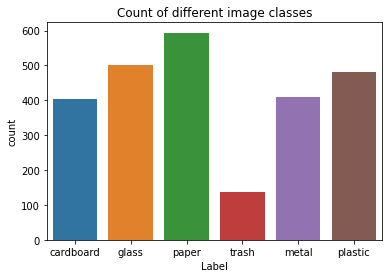

In [ ]:
sns.countplot(x='Label', data=image_df).set(title='Count of different image classes')
plt.show()

In [ ]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

transformations = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

dataset = ImageFolder(location, transform = transformations)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

Label: cardboard (Class No: 0)


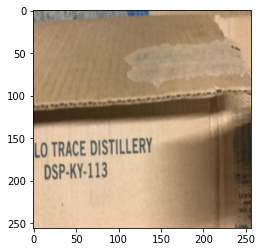

In [ ]:
img, label = dataset[12]
show_sample(img, label)

Label: glass (Class No: 1)


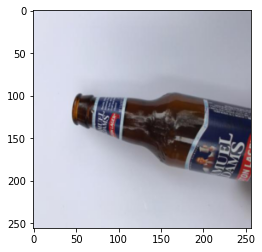

In [ ]:
img, label = dataset[700]
show_sample(img, label)

##DATASET PRE-PROCESSING

dataset reading and analylsis phase we resize every image 256x256 pixel
and trasfrom into tensor

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [1593, 176, 758])
print(f"number of classes: {len(dataset.classes)}")
print(f"total number of images: {len(dataset)}")
print(f"total number of train images: {len(train_ds)}")
print(f"total number of validation images: {len(val_ds)}")
print(f"total number of test images: {len(test_ds)}")


number of classes: 6
total number of images: 2527
total number of train images: 1593
total number of validation images: 176
total number of test images: 758


In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32

In [ ]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size=batch_size)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

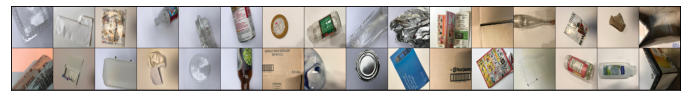

In [ ]:
show_batch(train_dl)

#TRAINING PHASE

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

##ResNet FUNCTION

In [ ]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
      
        self.network = models.resnet50(pretrained=True)
      
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

##CUDA FUNCTION CHECK AVAILABLE CPU OR GPU

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cpu')

##DEVICE DATALOADER FUNCTION PASS PREVIOUS DATALOADER AND AVALIABLE DEVICE

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

##TRAINING AND VALIDATION LOSS AND ACCURACY

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet(), device)

In [ ]:
evaluate(model, val_dl)

{'val_loss': 1.8006811141967773, 'val_acc': 0.1371527761220932}

In [ ]:
num_epochs = 8
opt_func = torch.optim.Adam
lr = 5.5e-5

history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch 1: train_loss: 1.4708, val_loss: 1.2721, val_acc: 0.8299
Epoch 2: train_loss: 1.1873, val_loss: 1.1819, val_acc: 0.9167
Epoch 3: train_loss: 1.1022, val_loss: 1.1422, val_acc: 0.9323
Epoch 4: train_loss: 1.0685, val_loss: 1.1262, val_acc: 0.9340
Epoch 5: train_loss: 1.0627, val_loss: 1.1165, val_acc: 0.9444
Epoch 6: train_loss: 1.0574, val_loss: 1.1264, val_acc: 0.9340
Epoch 7: train_loss: 1.0575, val_loss: 1.1177, val_acc: 0.9323
Epoch 8: train_loss: 1.0553, val_loss: 1.1351, val_acc: 0.9271


#TRAINING AND VALIDATION ACCURACY AND LOSS VISULAIZATION

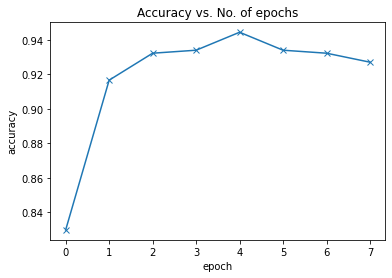

In [ ]:

    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');



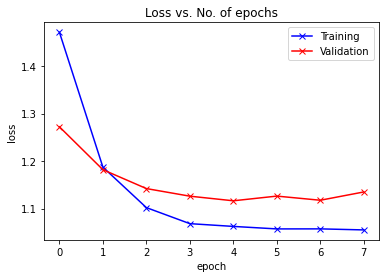

In [ ]:

    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');



#PREDICT IMAGE FROM TEST DATASET

In [ ]:
def predict_image(img, model):
   
    xb = to_device(img.unsqueeze(0), device)

    yb = model(xb)
  
    prob, preds  = torch.max(yb, dim=1)
    
    return dataset.classes[preds[0].item()]

Label: metal , Predicted: metal


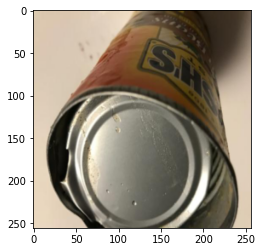

In [ ]:
img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: glass , Predicted: glass


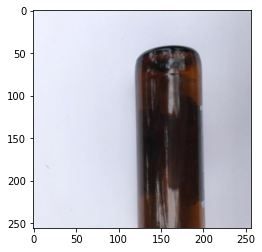

In [ ]:
img, label = test_ds[23]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: plastic , Predicted: plastic


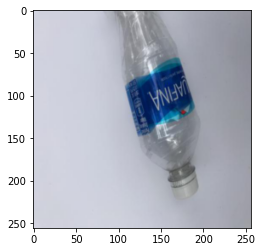

In [ ]:
img, label = test_ds[51]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model)) 

Label: paper , Predicted: paper


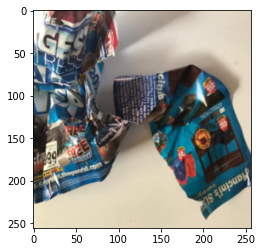

In [ ]:
img, label = test_ds[70]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model)) 

#PREDICT IMAGE FROM OUTSIDE TEST DATASET(IMAGE LINK)

In [ ]:
import urllib.request
urllib.request.urlretrieve("https://res.cloudinary.com/cse347/image/upload/v1672484393/external_image/plastic464_dgarfa.jpg", "plastic.jpg")
urllib.request.urlretrieve("https://res.cloudinary.com/cse347/image/upload/v1672484392/external_image/cardboard_ljvhhz.jpg", "cardboard.jpg")    
urllib.request.urlretrieve("https://res.cloudinary.com/cse347/image/upload/v1672484392/external_image/pepsi_can_qnurmn.jpg", "cans.jpg") 
urllib.request.urlretrieve("https://res.cloudinary.com/cse347/image/upload/v1673027553/external_image/paper578_rvqaov.jpg", "paper-trash.jpg")

('paper-trash.jpg', <http.client.HTTPMessage at 0x7efc492eb910>)

In [ ]:
loaded_model = model

In [ ]:
from PIL import Image
from pathlib import Path

def predict_external_image(image_name):
    image = Image.open(Path('./' + image_name))

    example_image = transformations(image)
    plt.imshow(example_image.permute(1, 2, 0))
    print("This image class is", predict_image(example_image, loaded_model) + ".")

This image class is metal.


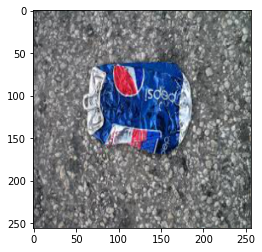

In [ ]:
predict_external_image('cans.jpg')

This image class is cardboard.


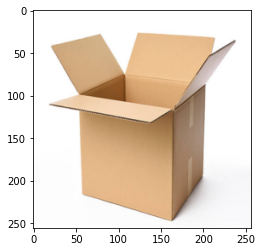

In [ ]:
predict_external_image('cardboard.jpg')

This image class is plastic.


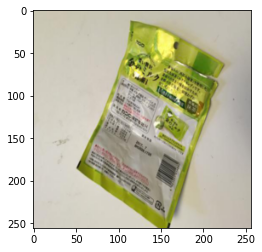

In [ ]:
predict_external_image('plastic.jpg')

This image class is paper.


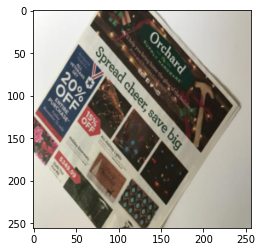

In [ ]:
predict_external_image('paper-trash.jpg')

# TESTING MULTICLASS ACCURACY SCORE

In [ ]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

In [ ]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    with tqdm(test_dl, unit="batch") as tepoch:
        for inp, labels in tepoch:
            inp, labels = inp.to(device), labels.to(device)
            y_test_pred = model(inp)
            acc =multi_acc(y_test_pred, labels)
            _, y_pred_tag = torch.max(y_test_pred, dim = 1)
            tepoch.set_postfix(accuracy = acc.item())
            y_pred_list.append(y_pred_tag.cpu().numpy())
            y_true_list.append(labels.cpu().numpy())

100%|██████████| 24/24 [03:20<00:00,  8.36s/batch, accuracy=91]


In [ ]:
flat_pred = []
flat_true = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        flat_pred.append(y_pred_list[i][j])
        flat_true.append(y_true_list[i][j])
        
print(f"number of testing samples results: {len(flat_pred)}")

number of testing samples results: 758


In [ ]:
print(f"Testing accuracy is: {accuracy_score(flat_true, flat_pred) * 100:.2f}%")

Testing accuracy is: 93.14%


#CLASSIFICATION REPORT(PRECISION,RECALL,f1-SCORE)

In [ ]:
print(classification_report(flat_true, flat_pred, target_names=dataset.classes))

              precision    recall  f1-score   support

   cardboard       0.96      0.94      0.95       113
       glass       0.91      0.94      0.93       144
       metal       0.95      0.97      0.96       129
       paper       0.93      0.98      0.95       175
     plastic       0.92      0.89      0.90       149
       trash       0.92      0.75      0.83        48

    accuracy                           0.93       758
   macro avg       0.93      0.91      0.92       758
weighted avg       0.93      0.93      0.93       758



#CONFUSION MATRIX

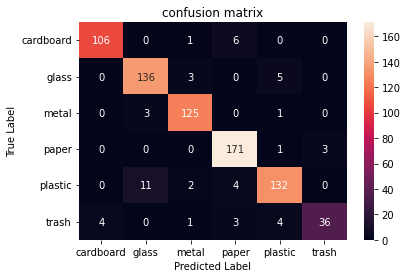

In [ ]:
idx2class = {v: k for k, v in dataset.class_to_idx.items()}
confusion_matrix_df = pd.DataFrame(confusion_matrix(flat_true, flat_pred)).rename(columns=idx2class, index=idx2class)
sns.heatmap(confusion_matrix_df, annot=True, fmt='').set(title="confusion matrix", xlabel="Predicted Label", ylabel="True Label")
plt.show()

#save model for future

In [ ]:
savePath='/content/drive/MyDrive/trainModel/train_model2.pth'
torch.save(model.state_dict(), savePath)

In [ ]:
torch.save(model, savePath)

In [ ]:
model = torch.load(savePath)

In [ ]:
model.eval()

ResNet(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (